In [53]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torch.autograd as autograd
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from logReg import LogitReg
from torch.nn import Parameter
from influence import *
from util import *
import hessian as hess
from pathlib import Path
import copy
from sklearn.metrics import mean_squared_error

In [4]:
'''training_data = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True),shuffle=True)
test_data =  torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True),shuffle=True)



X_train = training_data.dataset.train_data.data.reshape(-1,784).type(torch.FloatTensor)/255
y_train = training_data.dataset.train_labels.data
X_test = test_data.dataset.test_data.data.reshape(-1,784).type(torch.FloatTensor)/255
y_test = test_data.dataset.test_labels


np.savez("../data/training_data.npz", X=X_train, Y= y_train)
np.savez("../data/test_data.npz", X=X_test, Y= y_test)'''

X_train = torch.from_numpy(np.load("../data/training_data.npz")["X"])
y_train = torch.from_numpy(np.load("../data/training_data.npz")["Y"])
X_test = torch.from_numpy(np.load("../data/test_data.npz")["X"])
y_test = torch.from_numpy(np.load("../data/test_data.npz")["Y"])



max_iter = 100
D_in = X_train.shape[1]
D_out = 10
N = X_train.shape[0]
weight_decay = 0.01

cls = LogitReg(max_iter, D_in, D_out, N, weight_decay)
cls.fit(X_train,y_train)
print("Training loss {}".format(cls.loss_fn(X_train, y_train)))
print( "Training accuracy {}". format( cls.score(X_train,y_train)))
print( "Test loss {}". format( cls.loss_fn(X_test,y_test)))
print( "Test accuracy {}". format( cls.score(X_test,y_test)))


LBFGS training took [66] iter.
After training with LBFGS: 
Training loss 0.41001251339912415
a 53993.0 b 60000
Training accuracy 0.8998833298683167
Test loss 0.3923059105873108
a 9056.0 b 10000
Test accuracy 0.9056000113487244


In [ ]:
#def perturbation( model, x, y, epsilon = [0.01], weight = 0):
 #   x.requires_grad = True
  #  loss = model.loss_fn(x,y)
   # x_grads = torch.autograd.grad(loss, x)
    #x_grad = torch.cat([g.view(-1) for g in x_grads])
    
    #perturbed_ex = torch.zeros(len(epsilon_array), x.shape[1])
    
    #for i in range(len(epsilon_array)):
     #   e = epsilon_array[i]
      #  perturbed_ex[i,:] = weight*x + e * torch.sign(x_grad)
        
    #x.requires_grad = False
    #return perturbed_ex

In [ ]:
norm = []
params_diff = []
k = 10
epsilon = 0.001
res = np.load("../data/perturbation_1/loss_diffs_perturb_params_" + str(k) + "_" + str(epsilon) + "_" +".npz")["r"].item()


In [5]:
data = np.load("../data/perturbation_1/tr_indices_k_perturb.npz")["r"].item()["idx"]

57506
tensor([[-1.7427, -7.0629, -1.2577, -2.3611, -2.8488, -2.3899, -1.2677, -6.2982,
         -4.9545, -5.1937]], grad_fn=<LogSoftmaxBackward>)
tensor([[-1.7374, -7.0607, -1.2814, -2.3635, -2.8346, -2.3763, -1.2543, -6.2933,
         -4.9516, -5.1852]], grad_fn=<LogSoftmaxBackward>)
tensor([2])
tensor([6])


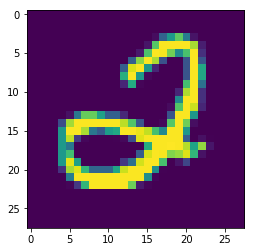

In [51]:
#print(np.nonzero(y_train[np.nonzero(data[0])]==8))
print(np.nonzero(data[0])[0][178])
tr_idx = np.nonzero(data[0])[0][178]
X_tr, y_tr, X_te, y_te = split_data( tr_idx, 8, X_train, y_train, X_test, y_test)
h = hess.Hessian( cls, X_train, y_train )
h.initialize(X_train, y_train)
X_pert = perturbation( cls, X_tr, y_tr, epsilon=0.001, weight=1 )
X_p = X_pert.detach().numpy() 
plt.imshow(X_train[tr_idx,].reshape(28,28))
#plt.imshow(X_p.reshape(28,28))

#plt.imsave("../final_plot/original.png",X_train[1387,].reshape(28,28))
print(cls.forward(X_train[tr_idx,].reshape(1,-1)))
print(cls.forward(X_pert.reshape(1,-1)))
print(cls.predict(X_train[tr_idx,].reshape(1,-1)))
print(cls.predict(X_pert.reshape(1,-1)))
#plt.imsave("../final_plot/perturbed.png",X_p.reshape(28,28))

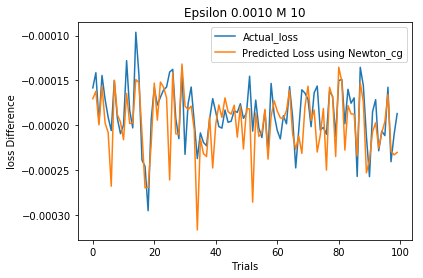

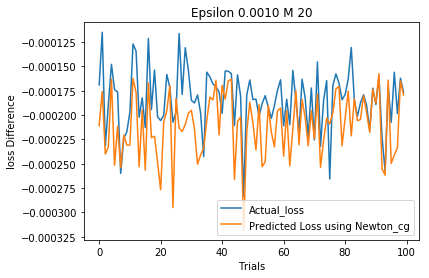

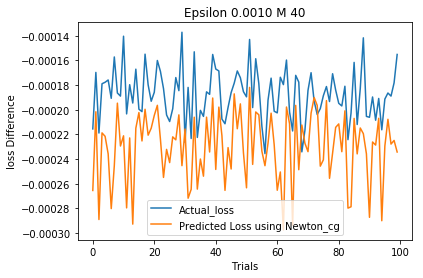

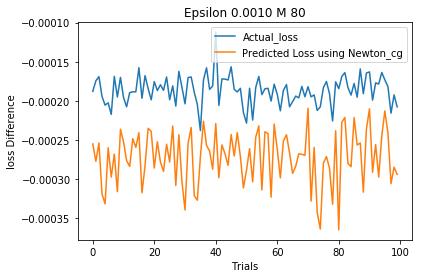

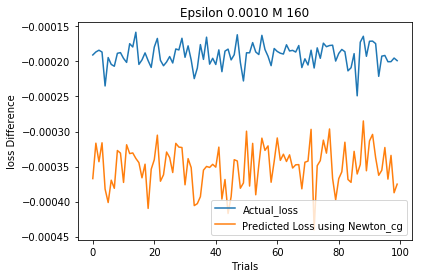

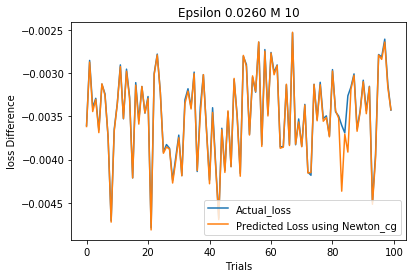

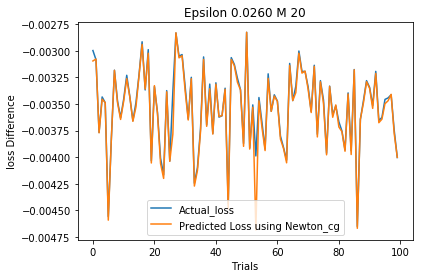

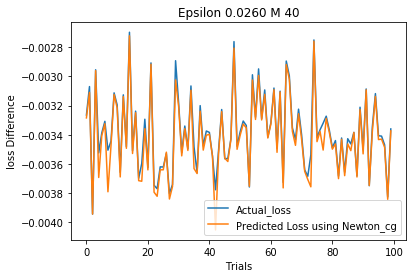

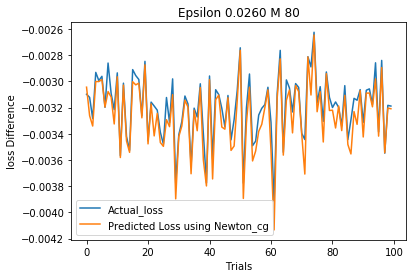

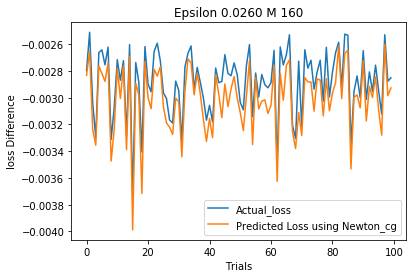

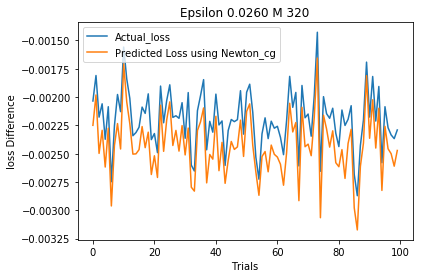

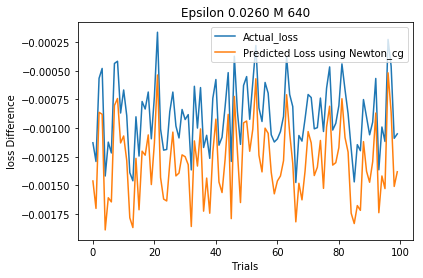

In [123]:
i = 0
data = np.load("../data/perturbation_1/tr_indices_k_perturb.npz")["r"].item()["idx"]
    
epsilon_array = np.load("../data/perturbation_1/tr_indices_k_perturb.npz")["r"].item()["epsilon_array"]
j = 0

params_diff = np.zeros((7,2))
loss_diff = np.zeros((7,2))
norm_diff = np.zeros((7,2))
while( i < 10):
    
    epsilon = epsilon_array[i]
    nz_data = np.nonzero(data[i])[0]
    
    k_array = []
    k = 10
    count = 0
    while( k <= 1000 ):
        if( k > nz_data.shape[0]):
            break
        params_res = np.load("../data/perturbation_1/loss_diffs_perturb_params_" + str(k) + "_" + 
                             str(epsilon) + "_" +".npz")["r"].item()
        loss_res = np.load("../data/perturbation_1/loss_diffs_k_perturb_" + str(k) + "_" + 
                             str(epsilon) + "_" +".npz")["r"].item()
        
        a_norm = np.sum(params_res["predicted_params"]**2, axis= 1)
        b_norm = np.sum(params_res["actual_params"]**2, axis= 1)
        params_diff[count, j] = np.sqrt(mean_squared_error(params_res["predicted_params"], params_res["actual_params"]))
        loss_diff[count,j] = np.sqrt(mean_squared_error(loss_res["predicted_loss"],loss_res["actual_loss"]))
        norm_diff[count,j] = np.sqrt(mean_squared_error(a_norm,b_norm))
        
      
        #plot
        fig, ax = plt.subplots()
        arr = range(100)
        ax.plot(arr, loss_res["actual_loss"], label='Actual_loss')
        ax.plot(arr, loss_res["predicted_loss"], label='Predicted Loss using Newton_cg')
        plt.xlabel("Trials")
        plt.ylabel("loss Difference")
        legend = ax.legend()
        plt.title("Epsilon %.4f M %d"%(epsilon,k))
        plt.savefig("Epsilon_{}_M_{}.png".format(epsilon,k))
        
        
        
        k = 2*k
        k_array.append(k)
        count = count + 1
    j = j + 1
    i = i+ 5

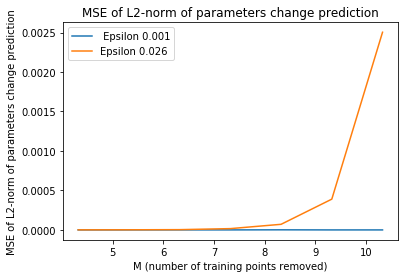

In [126]:
fig, ax = plt.subplots()
a = np.log2(k_array)
ax.plot(a, norm_diff[:,0], label=' Epsilon 0.001')
ax.plot(a, norm_diff[:,1], label='Epsilon 0.026')
plt.xlabel("M (number of training points removed)")
plt.ylabel("MSE of L2-norm of parameters change prediction")
legend = ax.legend(loc="upper left")
plt.title("MSE of L2-norm of parameters change prediction")
plt.savefig('../final_plot/norm_params_epsilon_change.png')

In [114]:
norm_diff[6,0] = float('nan')

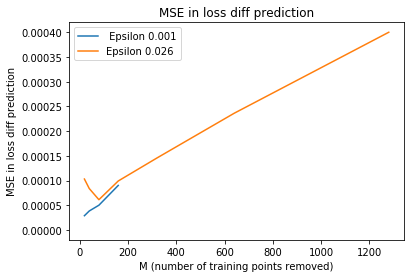

In [99]:
fig, ax = plt.subplots()
a = k_array
ax.plot(a, loss_diff[:,0], label=' Epsilon 0.001')
ax.plot(a, loss_diff[:,1], label='Epsilon 0.026')
plt.xlabel("M (number of training points removed)")
plt.ylabel("MSE in loss diff prediction")
legend = ax.legend(loc="upper left")
plt.title("MSE in loss diff prediction")
plt.savefig('../final_plot/epsilon_k_loss_change.png')

(100,)

In [98]:
loss_diff[4,0] = float('nan')
loss_diff[5,0] = float('nan')

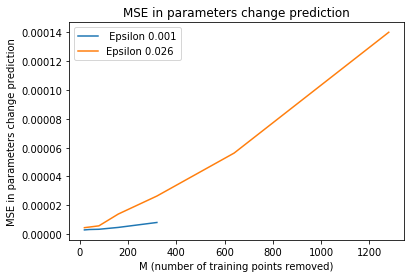

In [93]:
fig, ax = plt.subplots()
a = k_array
ax.plot(a, params_diff[:,0], label=' Epsilon 0.001')
ax.plot(a, params_diff[:,1], label='Epsilon 0.026')
plt.xlabel("M (number of training points removed)")
plt.ylabel("MSE in parameters change prediction")
legend = ax.legend(loc="upper left")
plt.title("MSE in parameters change prediction")
plt.savefig('../final_plot/epsilon_k_point_change.png')

In [92]:
params_diff[6,0] = float('nan')

In [94]:
params_diff

array([[2.92576993e-06, 4.48079991e-06],
       [3.20751287e-06, 4.90093380e-06],
       [3.37370234e-06, 5.75288134e-06],
       [4.65781357e-06, 1.39267195e-05],
       [8.08845029e-06, 2.64356461e-05],
       [           nan, 5.62915523e-05],
       [           nan, 1.40122001e-04]])

In [ ]:
i = 10
k = np.load("../data/perturbation_1/tr_indices_k_perturb.npz")["r"].item()["idx"]

epsilon_array = np.load("../data/perturbation_1/tr_indices_k_perturb.npz")["r"].item()["epsilon_array"]
while( i < len(epsilon_array)):
    influence_perurbation_k_leave(cls, X_train, y_train, X_test, y_test, verify_influence=True, 
                      epsilon = epsilon_array[i], epsilon_index = i, weight = 1, n_trials=100, load_refresh=True)
    i = i + 5

In [ ]:
def influence_perurbation_k_leave(model, X_train, y_train, X_test, y_test, epsilon_index = 0, n_trials = 1, random_seed=7, 
verify_influence = True, epsilon = 0.25, weight = 0, load_refresh=False):
    
    data = np.load("../data/perturbation_1/tr_indices_k_perturb.npz")["r"].item()["idx"]
    nz_data = np.nonzero(data[epsilon_index])[0]
    
    k = 160
    while( k <= 1000 ):
        if( k > nz_data.shape[0]):
            break

        all_tr_indices = np.zeros((n_trials,k))

        test_idx = 8
        N = model.num_train_examples
        actual_params_diff =  np.zeros((n_trials,7840))
        actual_loss_diff = np.zeros(n_trials)

        predicted_params_diff = np.zeros((n_trials,7840))
        predicted_loss_diff =  np.zeros(n_trials)
        K = 100


        for trial in range(n_trials):
            np.random.seed()
            indices_to_remove = np.random.choice(nz_data, k)
            print( "Epsilon: {} k {} trial {}\n".format(epsilon, k, trial))

            tr_indices = np.zeros(k)
            X_perturbed = torch.zeros(k,X_train.shape[1])
            y_perturbed = torch.zeros(k)

            for i in range(k):
                tr_idx = indices_to_remove[i]
                X_tr, y_tr, X_te, y_te = split_data( tr_idx, test_idx, X_train, y_train, X_test, y_test)
                h = hess.Hessian( model, X_train, y_train )
                h.initialize(X_train, y_train)
                X_pert = perturbation( model, X_tr, y_tr, epsilon=epsilon, weight=weight )

                tr_indices[i] = tr_idx
                X_perturbed[i,:] = X_pert
                y_perturbed[i] = y_tr

           
            all_tr_indices[trial,:] = tr_indices
            train_grad, train_loss = h.get_loss_gradient(X_train[tr_indices,:], y_train[tr_indices])
            perturb_train_grad, pert_loss = h.get_loss_gradient(X_perturbed, y_train[tr_indices])


            diff_v = train_grad -  perturb_train_grad
            v = diff_v.detach().numpy()
            hvp = np.array(h.get_inverse_hvp_cg(v, max_iterations = 100))*(k/N)

            predicted_params_diff[trial,:] = hvp
            predicted_loss_diff[trial] =  np.sum(hvp * train_grad.detach().numpy())

            if(verify_influence):
                cls_leave = LogitReg(model.iterations, model.D_in, model.D_out, N, model.weight_decay)
                X = X_train.clone()
                X[tr_indices, :] = X_perturbed.detach()
                y = y_train.clone()


                cls_leave.fit( X.detach(), y)

                actual_difference = cls_leave.fc1.weight.view(-1) - model.fc1.weight.view(-1)
                actual_params_diff[trial,:] = actual_difference.detach().numpy()
                actual_loss_diff[trial] = cls_leave.loss_fn(X_train[tr_indices,:], y_train[tr_indices]) - model.loss_fn(X_train[tr_indices,:], y_train[tr_indices])

                if( trial % K == 0):
                    print( "Predicted loss diff {} actual loss diff {}".format(predicted_loss_diff[trial], actual_loss_diff[trial]))

        np.savez("../data/perturbation_1/loss_diffs_k_perturb_" + str(k) + "_" + str(epsilon) + "_" +".npz",r = { 
                                                        "idx": all_tr_indices, 
                                                        "predicted_loss": predicted_loss_diff,
                                                        "actual_loss": actual_loss_diff})

        np.savez("../data/perturbation_1/loss_diffs_perturb_params_" + str(k) + "_" + str(epsilon) + "_" +".npz",r = { 
                                                        "idx": all_tr_indices, 
                                                        "predicted_params":predicted_params_diff, 
                                                        "actual_params": actual_params_diff }) 
        k = 2*k

In [ ]:
tr_indices = np.zeros((len(epsilon_array), N))
for i in range(X_train.shape[0]):
    X_tr = X_train[i,:].reshape(1,-1)
    orig_label = cls.predict(X_tr)
    y_tr =  y_train[i].reshape(1,)
    
    if( orig_label == y_tr):
        X_pert = perturbation( cls, X_tr , y_tr, epsilon=epsilon_array, weight=1 )
        pred_label = cls.predict(X_pert)

        for j in range(len(epsilon_array)):
            if( pred_label[j] != y_tr ):
                tr_indices[j,i] = 1
                print("Found {} orig_label {} perturbed label {}".format(i, y_tr, pred_label[j]))


np.savez("../data/perturbation_1/tr_indices_k_perturb.npz",r = { 
                                                    "idx": tr_indices,
                                                    "epsilon_array": epsilon_array})    
    